<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

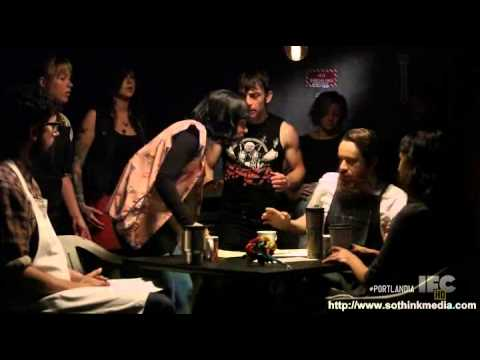

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [1]:
%pwd

'C:\\Users\\James B\\repos\\lambda_school_ds\\unit4\\DS-Unit-4-Sprint-1-NLP\\module1-text-data'

In [42]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [43]:
import seaborn as sns
import re
import numpy as np

In [44]:
dates = []

for ob in shops['full_review_text'].str.split(' '):
    dates.append(ob[1])
dates[:5]
# dates = []
# for text in shops['full_review_text']:
#     dates.append(re.findall(r'\b[0-3]?[0-9]/[0-3]?[0-9]/(?:[0-9]{2})?[0-9]{2}\b', text)[0])
# shops['review_date'] = dates

['11/25/2016', '12/2/2016', '11/30/2016', '11/25/2016', '12/3/2016']

In [45]:
shops['date'] = dates
shops.head()

,coffee_shop_name,full_review_text,star_rating,date
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,11/25/2016
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,12/2/2016
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,11/30/2016
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,11/25/2016
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,12/3/2016


In [46]:
def apply_regex(text):
    for strg in text:
        new = re.sub(r'[^a-zA-Z ^0-9]', '', text)
        return new

In [47]:
shops['full_review_text'] = shops['full_review_text'].apply(apply_regex)
shops['coffee_shop_name'] = shops['coffee_shop_name'].apply(apply_regex)

In [48]:
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: x.lower())

In [49]:
shops['full_review_text'] = [ob[2:] for ob in shops['full_review_text'].str.split(' ')]

In [50]:
shops['full_review_text'].head()

0    [1, checkin, love, love, loved, the, atmospher...
1    [listed, in, date, night, austin, ambiance, in...
2    [1, checkin, listed, in, brunch, spots, i, lov...
3    [very, cool, decor, good, drinks, nice, seatin...
4    [1, checkin, they, are, located, within, the, ...
Name: full_review_text, dtype: object

In [51]:
shops['coffee_shop_name'] = shops['coffee_shop_name'].apply(lambda x: x.lower())
shops['coffee_shop_name'] = shops['coffee_shop_name'].str.split(' ')
shops['coffee_shop_name'].head()

0    [the, factory, , cafe, with, a, soul, ]
1    [the, factory, , cafe, with, a, soul, ]
2    [the, factory, , cafe, with, a, soul, ]
3    [the, factory, , cafe, with, a, soul, ]
4    [the, factory, , cafe, with, a, soul, ]
Name: coffee_shop_name, dtype: object

In [52]:
shops['star_rating'] = shops['star_rating'].str.split(' ')

In [53]:
ratings = []
for rating in shops['star_rating']:
    ratings.append(rating[1])
shops['star_rating'] = ratings

In [54]:
# reviews = []
# shop_name = []
# for text in shops['full_review_text']:
#     reviews.append(' '.join(text))
# for name in shops['coffee_shop_name']:
#     shop_name.append(' '.join(name))
# shops['full_review_text'] = reviews
# shops['coffee_shop_name'] = shop_name

In [55]:
shops['star_rating']

0       5.0
1       4.0
2       4.0
3       2.0
4       4.0
       ... 
7611    4.0
7612    5.0
7613    4.0
7614    3.0
7615    4.0
Name: star_rating, Length: 7616, dtype: object

In [56]:
from collections import Counter

word_counts = Counter()
shops['full_review_text'].apply(lambda x: word_counts.update(x))
word_counts.most_common(20)

[('the', 34809),
 ('', 29517),
 ('and', 26650),
 ('a', 22755),
 ('i', 20237),
 ('to', 17164),
 ('of', 12600),
 ('is', 11999),
 ('coffee', 10353),
 ('was', 9707),
 ('in', 9546),
 ('it', 9379),
 ('for', 8680),
 ('this', 6583),
 ('but', 6501),
 ('with', 6332),
 ('my', 6202),
 ('they', 6165),
 ('that', 6151),
 ('you', 5847)]

In [57]:
word_counts_name = Counter()
shops['coffee_shop_name'].apply(lambda x: word_counts_name.update(x))
word_counts_name.most_common(20)

[('', 8334),
 ('coffee', 3307),
 ('cafe', 788),
 ('the', 554),
 ('bar', 500),
 ('epoch', 400),
 ('coffeehouse', 300),
 ('halcyon', 300),
 ('factory', 244),
 ('with', 244),
 ('a', 244),
 ('soul', 244),
 ('medici', 243),
 ('beer', 236),
 ('austin', 231),
 ('caf', 200),
 ('venezia', 200),
 ('italian', 200),
 ('gelato', 200),
 ('houndstooth', 200)]

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [58]:
# word count function => pandas dataframe
def count(docs):
    
    word_counts = Counter()
    appears_in = Counter()
    
    total_docs = len(docs)
    
    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))
        
    temp = zip(word_counts.keys(), word_counts.values())
    
    wc = pd.DataFrame(temp, columns=['word', 'count'])
    
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()
    
    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
    
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()
    
    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')
    
    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
    
    return wc.sort_values(by='rank')

In [59]:
wc_review = count(shops['full_review_text'])
wc_review.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
56,the,6847,34809,1.0,0.043323,0.043323,0.899028
2,,7616,29517,2.0,0.036736,0.080059,1.000000
0,and,6864,26650,3.0,0.033168,0.113227,0.901261
26,a,6246,22755,4.0,0.028320,0.141548,0.820116
37,i,5528,20237,5.0,0.025187,0.166734,0.725840


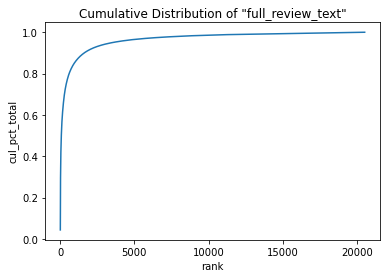

In [60]:
sns.lineplot(x='rank', y='cul_pct_total', data=wc_review).set_title('Cumulative Distribution of "full_review_text"');

In [64]:
shops[shops['star_rating']=='5.0']

,coffee_shop_name,full_review_text,star_rating,date
0,"[the, factory, , cafe, with, a, soul, ]","[1, checkin, love, love, loved, the, atmospher...",5.0,11/25/2016
7,"[the, factory, , cafe, with, a, soul, ]","[2, checkins, love, this, place, , 5, stars, f...",5.0,11/2/2016
9,"[the, factory, , cafe, with, a, soul, ]","[3, checkins, this, place, has, been, shown, o...",5.0,11/10/2016
13,"[the, factory, , cafe, with, a, soul, ]","[this, is, such, a, cute, little, cafe, ive, d...",5.0,12/5/2016
14,"[the, factory, , cafe, with, a, soul, ]","[beautiful, eccentric, coffee, shop, with, a, ...",5.0,11/13/2016
...,...,...,...,...
7599,"[the, steeping, room, ]","[1, checkin, i, am, someone, that, hates, goin...",5.0,3/28/2015
7605,"[the, steeping, room, ]","[i, got, the, chipotle, chocolate, chai, tea, ...",5.0,10/22/2015
7607,"[the, steeping, room, ]","[this, place, is, amazing, its, one, of, my, f...",5.0,8/14/2015
7610,"[the, steeping, room, ]","[great, food, i, havent, had, a, meal, i, did,...",5.0,3/1/2016


In [65]:
# I had some issues converting the floats to ints and after rerunning
# the code, they are currently strings so, I just decided to make a
# new column containing true/false values for star_rating >= 4.0
rate_bool = []
for n in shops['star_rating']:
    if n=='5.0' or n=='4.0':
        rate_bool.append(1)
    else:
        rate_bool.append(0)
shops['is_good'] = rate_bool

In [67]:
# Word Count Dataframe of only 'good' coffee shops
shops['is_good'].value_counts()

1    6140
0    1476
Name: is_good, dtype: int64

In [68]:
# Take a subset where star_rating >= 4.0
subset_good = shops[shops['is_good']==1]
subset_bad = shops[shops['is_good']==0]

In [75]:
wc_good = count(subset_good['full_review_text'])
wc_bad = count(subset_bad['full_review_text'])
wc_good.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
56,the,5479,26616,1.0,0.043014,0.043014,0.892345
2,,6140,23354,2.0,0.037742,0.080756,1.000000
0,and,5545,21311,3.0,0.034440,0.115196,0.903094
26,a,4983,17706,4.0,0.028614,0.143810,0.811564
37,i,4344,14952,5.0,0.024164,0.167974,0.707492


In [76]:
len(set(wc_good['word']))

17782

In [80]:
print(len(set(wc_bad['word'])), 'total words for shops less than 4.0 rating')
wc_bad.head()

9420 total words for shops less than 4.0 rating


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
44,the,1368,8193,1.0,0.044358,0.044358,0.926829
0,,1476,6163,2.0,0.033367,0.077725,1.000000
1,and,1319,5339,3.0,0.028906,0.106631,0.893631
167,i,1184,5285,4.0,0.028614,0.135245,0.802168
17,a,1263,5049,5.0,0.027336,0.162581,0.855691


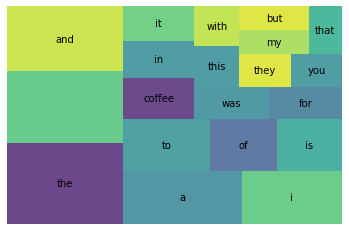

In [82]:
import squarify
import matplotlib.pyplot as plt

# Relative importance for good shops
wc_top20 = wc_good[wc_good['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [ ]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

